In [1]:
import requests
import ast
import asyncio
import httpx
import pandas as pd
from tqdm.asyncio import tqdm
import nest_asyncio
import re
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

In [57]:
def sreality_scrape():
    """Scrapes flat listings from Sreality.cz for Prague based on building conditions.
    """
    BASE_URL = (
        "https://www.sreality.cz/api/v1/estates/search?"
        "category_main_cb=1"
        "&category_type_cb=1"
        "&locality_country_id=112"
        "&locality_region_id=10"
        "&building_condition={condition}"
        "&ownership=1"
        "&limit={limit}"
        "&offset={offset}"
        "&sort=-date"
        "&lang=cs"
    )

    limit = 22
    all_dfs = []

    condition_map = {
        1: "very good",
        2: "good",
        4: "in development",
        6: "new"
    }

    for condition_code, condition_name in condition_map.items():
        print(f"\nDownloading flats: {condition_name}")
        offset = 0
        total_results = float("inf")
        all_results = []

        try:
            while offset < total_results:
                url = BASE_URL.format(
                    condition=condition_code,
                    limit=limit,
                    offset=offset
                )

                response = requests.get(url)
                response.raise_for_status()
                data = response.json()

                results = data.get("results", [])
                if not results:
                    break

                all_results.extend(results)

                if total_results == float("inf"):
                    total_results = data["pagination"]["total"]

                offset += limit

            df = pd.DataFrame(all_results)
            df["condition"] = condition_name

            print(f"{len(df)} flats downloaded ({condition_name})")
            all_dfs.append(df)
            
        except requests.exceptions.RequestException as e:
            print(f"Error for condition {condition_name}: {e}")

    # Return concatenated DataFrame
    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    return pd.DataFrame()

data = sreality_scrape()


1193 flats downloaded (very good)

323 flats downloaded (good)

447 flats downloaded (in development)

921 flats downloaded (new)


In [58]:
hash_id = data["hash_id"].to_list()

In [59]:
len(hash_id)

2884

In [60]:
estates_list = hash_id

# Apply nest_asyncio to allow nested loops (higher speed, avoiding RuntimeError)
nest_asyncio.apply()

MAX_CONCURRENT_REQUESTS = 10

async def get_estate_detail(client, hash_id, semaphore):
    url = f"https://www.sreality.cz/api/cs/v2/estates/{hash_id}"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    async with semaphore:
        try:
            # Short delay to avoid overwhelming the server
            await asyncio.sleep(0.05) 
            r = await client.get(url, headers=headers, timeout=15)
            r.raise_for_status()
            data_json = r.json()
            
            # Getting only "items" detail
            items = data_json.get("items", [])
            detail = items if items else None
            return {'hash_id': hash_id, 'detail': detail}
        except Exception as e:
            return {'hash_id': hash_id, 'detail': f"Chyba: {e}"}

async def run_scraping(hash_ids):
    semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
    # Tiumeout increasing for many concurrent requests
    limits = httpx.Limits(max_keepalive_connections=5, max_connections=MAX_CONCURRENT_REQUESTS)
    
    async with httpx.AsyncClient(limits=limits, follow_redirects=True) as client:
        tasks = [get_estate_detail(client, hid, semaphore) for hid in hash_ids]
        
        # tqdm progress bar
        results = await tqdm.gather(*tasks)
        return results

results = await run_scraping(estates_list)

estates_details_df = pd.DataFrame(results)
print(f"\nSuccess. {len(estates_details_df)} records downloaded.")

100%|██████████| 2884/2884 [02:09<00:00, 22.34it/s]


Success. 2884 records downloaded.


In [61]:
estates_details_df.head(5)
data.to_csv("data.csv", index=False)

In [62]:
df = estates_details_df.merge(data, on='hash_id', how='left')
len(df)

2884

In [63]:
df["detail"][0]

[{'negotiation': False,
  'name': 'Celková cena',
  'notes': [],
  'value': '22\xa0950\xa0000',
  'currency': 'Kč',
  'type': 'price_czk',
  'unit': 'za nemovitost'},
 {'type': 'string',
  'name': 'Poznámka k ceně',
  'value': 'včetně provize, včetně právního servisu'},
 {'type': 'string', 'name': 'ID zakázky', 'value': '01198'},
 {'type': 'edited', 'name': 'Aktualizace', 'value': 'Dnes', 'topped': True},
 {'type': 'string', 'name': 'Stavba', 'value': 'Cihlová'},
 {'type': 'string', 'name': 'Stav objektu', 'value': 'Velmi dobrý'},
 {'type': 'string', 'name': 'Vlastnictví', 'value': 'Osobní'},
 {'type': 'string', 'name': 'Podlaží', 'value': '4. podlaží'},
 {'unit': 'm2', 'type': 'area', 'name': 'Užitná ploch', 'value': '141'},
 {'type': 'boolean', 'name': 'Balkón', 'value': True},
 {'value_type': 'E',
  'type': 'energy_efficiency_rating',
  'name': 'Energetická náročnost budovy',
  'value': 'Třída E - Nehospodárná č. 264/2020 Sb. podle vyhlášky'},
 {'unit2': 'za rok',
  'unit': 'kWh/m^2

In [9]:
df = df.copy()

# Odstranění nepotřebných sloupců (metadata, obrázky, loga atd.)
cols_to_drop = [
    'Unnamed: 0', 'hash_id', 'advert_images', 'advert_images_all', 
    'premise_logo', 'user_id', 'premise_id', 'price_summary', 
    'price_currency_cb', 'price_unit_cb', 'price_summary_unit_cb', 
    'has_matterport_url', 'has_video', 'advert_name', 'premise'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

# Remove rows with missing price
df = df.dropna(subset=['price_czk'])
df = df.reset_index(drop=True)

# Function to safely evaluate strings to dicts/lists
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return None

In [10]:
df

,detail,category_main_cb,category_sub_cb,category_type_cb,discount_show,locality,poi_atm_distance,poi_bus_public_transport_distance,poi_kindergarten_distance,poi_medic_distance,...,poi_school_distance,poi_shop_distance,poi_small_shop_distance,poi_train_distance,poi_vet_distance,price,price_czk,price_czk_m2,price_summary_czk,condition
0,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '2+kk', 'value': 4}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",172,164,92,601,...,129,1118,449,810,448,7505000.0,7505000.0,187625,7505000.0,very good
1,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '2+kk', 'value': 4}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",289,125,573,438,...,194,683,251,1830,1086,13950000.0,13950000.0,208209,13950000.0,very good
2,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '2+kk', 'value': 4}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",196,626,275,128,...,217,1429,519,673,405,9490000.0,9490000.0,220698,9490000.0,very good
3,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '3+kk', 'value': 6}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",1426,161,315,247,...,155,2254,172,761,658,17990000.0,17990000.0,122381,17990000.0,very good
4,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '1+kk', 'value': 2}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",425,156,231,294,...,471,1449,722,896,623,8300000.0,8300000.0,162745,8300000.0,very good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '3+kk', 'value': 6}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",930,251,334,979,...,579,930,436,1726,947,19716200.0,19716200.0,214307,19716200.0,new
2891,"[{'negotiation': False, 'type': 'price_info', ...","{'name': 'Byty', 'value': 1}","{'name': '5+kk', 'value': 10}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",388,220,622,818,...,455,1614,1187,1742,530,0.0,0.0,0,0.0,new
2892,"[{'negotiation': False, 'type': 'price_info', ...","{'name': 'Byty', 'value': 1}","{'name': '4+kk', 'value': 8}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",393,92,193,540,...,332,480,887,1895,843,0.0,0.0,0,0.0,new
2893,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '3+kk', 'value': 6}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",404,82,677,176,...,72,713,66,453,1356,11634400.0,11634400.0,157222,11634400.0,new


In [11]:
df["detail"][0]

[{'negotiation': False,
  'name': 'Celková cena',
  'notes': [],
  'value': '7\xa0505\xa0000',
  'currency': 'Kč',
  'type': 'price_czk',
  'unit': 'za nemovitost'},
 {'type': 'string', 'name': 'ID zakázky', 'value': '0330-NP00293'},
 {'type': 'edited', 'name': 'Aktualizace', 'value': 'Dnes', 'topped': True},
 {'type': 'string', 'name': 'Stavba', 'value': 'Cihlová'},
 {'type': 'string', 'name': 'Stav objektu', 'value': 'Velmi dobrý'},
 {'type': 'string', 'name': 'Vlastnictví', 'value': 'Osobní'},
 {'type': 'string', 'name': 'Umístění objektu', 'value': 'Centrum obce'},
 {'type': 'string', 'name': 'Podlaží', 'value': '5. podlaží z celkem 5'},
 {'unit': 'm2', 'type': 'area', 'name': 'Užitná ploch', 'value': '40'},
 {'type': 'integer', 'name': 'Rok kolaudace', 'value': 1919},
 {'value_type': 'G',
  'type': 'energy_efficiency_rating',
  'name': 'Energetická náročnost budovy',
  'value': 'Třída G - Mimořádně nehospodárná č. 264/2020 Sb. podle vyhlášky'}]

In [12]:
# Function to parse the 'detail' column
def parse_details_list(details_list):
    extracted = {}
    
    # If the details_list is a string, try to convert it to a list
    if isinstance(details_list, str):
        try:
            details_list = ast.literal_eval(details_list)
        except:
            return extracted

    if not isinstance(details_list, list):
        return extracted

    # Iterate through each item in list
    for item in details_list:
        if isinstance(item, dict):
            name = item.get('name')
            value = item.get('value')
            
            #  Define the mappings based on 'name'
            if name == 'Stav objektu':
                extracted['building_condition'] = value
            elif name in ('Užitná plocha', 'Užitná ploch'):
                extracted['usable_area'] = value
            elif name == 'Stavba':
                extracted['building_type'] = value
            elif name == 'Celková cena':
                extracted['price'] = value
            elif name == 'Terasa':
                extracted['terrace'] = value
            elif name == 'Výtah':
                extracted['elevator'] = value
            elif name == 'Podlaží':
                extracted['floor'] = value

    return extracted

def extract_details(detail):
    if isinstance(detail, str):
        try:
            detail = ast.literal_eval(detail)
        except:
            return {}
    if not isinstance(detail, list):
        return {}   
    details_dict = {}
    for item in detail:
        if isinstance(item, dict):
            name = item.get('name')
            value = item.get('value')
            details_dict[name] = value
    return details_dict

def extract_name(category_cb):
    if isinstance(category_cb, str):
        try:
            category_cb = ast.literal_eval(category_cb)
        except:
            return None
    if isinstance(category_cb, dict):
        return category_cb.get('name')
    return None

# Extract property details
details_extracted = df['detail'].apply(parse_details_list)

# Convert list-of-dicts into dataframe and concat
details_df = pd.DataFrame(details_extracted.tolist())

df = pd.concat([df, details_df], axis=1)

print(df.columns)
details_extracted = df['category_main_cb'].apply(extract_details)
details_df = pd.DataFrame(details_extracted.tolist())

Index(['detail', 'category_main_cb', 'category_sub_cb', 'category_type_cb',
       'discount_show', 'locality', 'poi_atm_distance',
       'poi_bus_public_transport_distance', 'poi_kindergarten_distance',
       'poi_medic_distance', 'poi_metro_distance', 'poi_playground_distance',
       'poi_post_office_distance', 'poi_restaurant_distance',
       'poi_school_distance', 'poi_shop_distance', 'poi_small_shop_distance',
       'poi_train_distance', 'poi_vet_distance', 'price', 'price_czk',
       'price_czk_m2', 'price_summary_czk', 'condition', 'price',
       'building_type', 'building_condition', 'floor', 'usable_area',
       'elevator', 'terrace'],
      dtype='object')


In [13]:
locality_df = pd.json_normalize(df['locality'])

def extract_name(x):
    d = safe_eval(x)
    return d.get('name') if isinstance(d, dict) else None

df['city'] = locality_df['city']
df['district'] = locality_df.get('district')
df['lat'] = locality_df.get('gps_lat')
df['lon'] = locality_df.get('gps_lon')


In [14]:
df

,detail,category_main_cb,category_sub_cb,category_type_cb,discount_show,locality,poi_atm_distance,poi_bus_public_transport_distance,poi_kindergarten_distance,poi_medic_distance,...,building_type,building_condition,floor,usable_area,elevator,terrace,city,district,lat,lon
0,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '2+kk', 'value': 4}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",172,164,92,601,...,Cihlová,Velmi dobrý,5. podlaží z celkem 5,40,NaN,NaN,Praha,Praha 3,50.085363,14.447667
1,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '2+kk', 'value': 4}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",289,125,573,438,...,Cihlová,Velmi dobrý,3. podlaží z celkem 5 včetně 1 podzemního,67,False,NaN,Praha,Praha 5,50.077742,14.407670
2,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '2+kk', 'value': 4}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",196,626,275,128,...,Cihlová,Velmi dobrý,1. podlaží z celkem 4 včetně 1 podzemního,43,True,11,Praha,Praha 10,50.070650,14.449091
3,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '3+kk', 'value': 6}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",1426,161,315,247,...,Cihlová,Velmi dobrý,6. podlaží z celkem 6 včetně 2 podzemních,147,True,True,Praha,Praha 5,50.068352,14.370967
4,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '1+kk', 'value': 2}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",425,156,231,294,...,Cihlová,Velmi dobrý,2. podlaží z celkem 5 včetně 1 podzemního,51,True,NaN,Praha,Praha 4,50.033314,14.415456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '3+kk', 'value': 6}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",930,251,334,979,...,Smíšená,Novostavba,3. podlaží z celkem 3 včetně 2 podzemních,92,True,72,Praha,Praha 6,50.066586,14.321632
2891,"[{'negotiation': False, 'type': 'price_info', ...","{'name': 'Byty', 'value': 1}","{'name': '5+kk', 'value': 10}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",388,220,622,818,...,Cihlová,Novostavba,11. podlaží z celkem 11,231,True,111,Praha,Praha 10,50.079335,14.483161
2892,"[{'negotiation': False, 'type': 'price_info', ...","{'name': 'Byty', 'value': 1}","{'name': '4+kk', 'value': 8}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",393,92,193,540,...,Skeletová,Novostavba,24. podlaží z celkem 30,190,True,True,Praha,Praha 4,50.048577,14.431812
2893,"[{'negotiation': False, 'name': 'Celková cena'...","{'name': 'Byty', 'value': 1}","{'name': '3+kk', 'value': 6}","{'name': 'Prodej', 'value': 1}",False,"{'city': 'Praha', 'city_seo_name': 'praha', 'c...",404,82,677,176,...,Smíšená,Novostavba,4. podlaží z celkem 6,74,True,NaN,Praha,Praha 5,50.035247,14.314073


In [15]:
def extract_floor_num(floor_str):
    if not isinstance(floor_str, str):
        return 0 # Default
    floor_str = floor_str.lower()
    if 'přízemí' in floor_str:
        return 0
    elif 'suterén' in floor_str:
        return -1
    # Finds the first number in the string (e.g. "2. patro" -> 2)
    match = re.search(r'(-?\d+)', floor_str)
    if match:
        return int(match.group(1))
    return 0

if 'floor' in df.columns:
    df['floor_num'] = df['floor'].apply(extract_floor_num)

for col in ['terrace', 'elevator']:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

cols_to_remove = ['locality', 'locality_dict', 'detail', 'price', 'price_czk_m2', 'price_summary_czk', 'building_condition', 'floor', 'discount_show']
df = df.drop(columns=cols_to_remove, errors='ignore')

categorical_cols = [
    'category_main_cb', 'category_sub_cb', 'category_type_cb', 
    'city', 'district', 'building_type', 'building_condition', 
    'ownership', 'condition'
]
categorical_cols = [c for c in categorical_cols if c in df.columns]

# Extract 'name' field from dictionary columns before encoding
for col in categorical_cols:
    if df[col].dtype == 'object':
        # Check if the column contains dictionaries
        if df[col].apply(lambda x: isinstance(x, dict)).any():
            df[col] = df[col].apply(lambda x: x.get('name') if isinstance(x, dict) else x)

dist_cols = [col for col in df.columns if col.startswith('poi_')]

for col in dist_cols:
    new_col_name = col.replace('poi_', '500m_')
    # 1 if dist <= 500, else 0
    df[new_col_name] = (df[col] <= 500).astype(int)

df.drop(columns=dist_cols, inplace=True)

# Dummy encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Median imputation for any remaining NaNs in numeric columns

# numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
# df_encoded[numeric_cols] = df_encoded[numeric_cols].fillna(df_encoded[numeric_cols].median())

#print(f"Data ready! Shape: {df_encoded.shape}")
df_encoded.transpose()

,0,1,2,3,4,5,6,7,8,9,...,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894
price_czk,7505000.0,13950000.0,9490000.0,17990000.0,8300000.0,23990000.0,7290000.0,7290000.0,19700000.0,6570000.0,...,17678889.0,19054735.0,6776000.0,19054735.0,21986700.0,19716200.0,0.0,0.0,11634400.0,0.0
usable_area,40,67,43,147,51,169,44,44,126,53,...,108,119,51,119,109,92,231,190,74,440
elevator,0,0,1,1,1,0,0,0,1,0,...,1,1,1,0,1,1,1,1,1,1
terrace,0,0,11,1,0,45,0,0,0,0,...,1,1,0,37,33,72,111,1,0,230
lat,50.085363,50.077742,50.07065,50.068352,50.033314,50.036203,50.054125,50.054125,50.072838,50.070191,...,50.114468,50.114468,50.134702,50.114339,50.066882,50.066586,50.079335,50.048577,50.035247,50.035347
lon,14.447667,14.40767,14.449091,14.370967,14.415456,14.343525,14.44177,14.44177,14.381351,14.399321,...,14.509069,14.509069,14.51004,14.507672,14.321302,14.321632,14.483161,14.431812,14.314073,14.387866
floor_num,5,3,1,6,2,2,2,2,2,5,...,5,5,1,5,3,3,11,24,4,6
500m_atm_distance,1,1,1,0,1,1,1,1,0,1,...,1,1,1,1,0,0,1,1,1,1
500m_bus_public_transport_distance,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
500m_kindergarten_distance,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,0


In [16]:
df_encoded = df_encoded[df_encoded["price_czk"]>1000000]
bool_cols = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

df_encoded

,price_czk,usable_area,elevator,terrace,lat,lon,floor_num,500m_atm_distance,500m_bus_public_transport_distance,500m_kindergarten_distance,...,building_type_Dřevostavba,building_type_Kamenná,building_type_Modulární,building_type_Montovaná,building_type_Panelová,building_type_Skeletová,building_type_Smíšená,condition_in development,condition_new,condition_very good
0,7505000.0,40,0,0,50.085363,14.447667,5,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,13950000.0,67,0,0,50.077742,14.407670,3,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9490000.0,43,1,11,50.070650,14.449091,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,17990000.0,147,1,1,50.068352,14.370967,6,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,8300000.0,51,1,0,50.033314,14.415456,2,1,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,6776000.0,51,1,0,50.134702,14.510040,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2888,19054735.0,119,0,37,50.114339,14.507672,5,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2889,21986700.0,109,1,33,50.066882,14.321302,3,0,1,1,...,0,0,0,0,0,0,1,0,1,0
2890,19716200.0,92,1,72,50.066586,14.321632,3,0,1,1,...,0,0,0,0,0,0,1,0,1,0


In [17]:
# Define a mapping dictionary
column_mapping = {
    # Original : New, snake_case
    'price_czk': 'price',
    'lat': 'latitude',
    'lon': 'longitude',
    'usable_area': 'area_usable',
    'terrace': 'has_terrace',
    'elevator': 'has_elevator',
    'floor_num': 'floor_number',
    
    # One-hot encoded columns (cleaning up the prefixes)
    'category_sub_cb_1+kk': 'layout_1kk',
    'category_sub_cb_2+1': 'layout_21',
    'category_sub_cb_2+kk': 'layout_2kk',
    'category_sub_cb_3+1': 'layout_31',
    'category_sub_cb_3+kk': 'layout_3kk',
    'category_sub_cb_4+1': 'layout_41',
    'category_sub_cb_4+kk': 'layout_4kk',
    'category_sub_cb_5+1': 'layout_51',
    'category_sub_cb_5+kk': 'layout_5kk',
    'category_sub_cb_6 a více': 'layout_6_plus',
    'category_sub_cb_Atypický': 'layout_atypical',
    
    'district_Praha 1': 'district_praha_1',
    'district_Praha 10': 'district_praha_10',
    'district_Praha 2': 'district_praha_2',
    'district_Praha 3': 'district_praha_3',
    'district_Praha 4': 'district_praha_4',
    'district_Praha 5': 'district_praha_5',
    'district_Praha 6': 'district_praha_6',
    'district_Praha 7': 'district_praha_7',
    'district_Praha 8': 'district_praha_8',
    'district_Praha 9': 'district_praha_9',
    
    'building_type_Dřevostavba': 'building_type_wood',
    'building_type_Kamenná': 'building_type_stone',
    'building_type_Modulární': 'building_type_modular',
    'building_type_Montovaná': 'building_type_assembled',
    'building_type_Panelová': 'building_type_panel',
    'building_type_Skeletová': 'building_type_skeleton',
    'building_type_Smíšená': 'building_type_mixed',
    
    'building_condition_Novostavba': 'condition_new_build',
    'building_condition_Ve výstavbě': 'condition_under_construction',
    'building_condition_Velmi dobrý': 'condition_very_good',
    
    'condition_in development': 'status_development',
    'condition_new': 'status_new',
    'condition_very good': 'status_very_good'
}

# Apply renaming
df_encoded = df_encoded.rename(columns=column_mapping)

In [18]:
metro = pd.read_csv("metro_stations.csv")

In [19]:
def haversine(lon1, lat1, lon2, lat2):
    #  Radians conversion
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r

In [20]:
from math import radians, cos, sin, asin, sqrt

def get_metro_distances(row):
    flat_lat = row['latitude']
    flat_lon = row['longitude']
    
    results = {
        'dist_A': 99999,
        'dist_B': 99999,
        'dist_C': 99999,
        'nearest_name': None,
        'global_min_dist': 99999
    }
    
    # Iterace přes všechny stanice metra
    for _, station in metro.iterrows():
        station_line = station['line']
        station_name = station['name']
        station_lat = station['lat']
        station_lng = station['lng']
        
        # Harversine distance calculation
        dist = haversine(flat_lon, flat_lat, station_lng, station_lat)
        
        # Minimum for specific line (A, B, C)
        col_name = f'dist_{station_line}' 
        
        if col_name in results:
            if dist < results[col_name]:
                results[col_name] = dist
        
        # Global min
        if dist < results['global_min_dist']:
            results['global_min_dist'] = dist
            results['nearest_name'] = station_name

    return pd.Series([
        results['dist_A'], 
        results['dist_B'], 
        results['dist_C'], 
        results['nearest_name']
    ])

df_encoded[['metro_dist_A', 'metro_dist_B', 'metro_dist_C', 'nearest_station']] = df_encoded.apply(get_metro_distances, axis=1)

# Check the result
print(df_encoded[['latitude', 'longitude', 'metro_dist_A', 'metro_dist_B', 'metro_dist_C', 'nearest_station']].head())

    latitude  longitude  metro_dist_A  metro_dist_B  metro_dist_C  \
0  50.085363  14.447667    868.651444    822.114976    825.171334   
1  50.077742  14.407670   1341.529884    776.437745   1614.276008   
2  50.070650  14.449091    773.884207   2198.825046   1460.279843   
3  50.068352  14.370967   2279.722202   1544.116661   4279.596274   
4  50.033314  14.415456   4917.469596   3193.252750   2621.595898   

     nearest_station  
0            Florenc  
1              Anděl  
2  Jiřího z Poděbrad  
3           Jinonice  
4            Pankrác  


In [21]:
dist_cols = [col for col in df_encoded.columns if col.startswith('metro_') and col in df_encoded.columns]
for col in dist_cols:
    new_col_name = col.replace('metro_', '1000m_')
    # 1 if dist <= 1000, else 0
    df_encoded[new_col_name] = (df_encoded[col] <= 1000).astype(int)

In [22]:
df_encoded.to_csv("data_estate_processed.csv", index=False)

In [23]:
df_encoded = pd.get_dummies(df_encoded, columns=['nearest_station'], drop_first=True)

Station Market Analysis

Top 10 Most Expensive Stations:
                    avg_price_m2  min_price_m2  max_price_m2  count
nearest_station                                                    
Staroměstská            264332.0      184608.0      410377.0     24
Muzeum                  232170.0      131279.0      356421.0     16
Národní třída           209139.0      128662.0      363636.0     19
Jiřího z Poděbrad       208056.0       95181.0      320417.0     70
Malostranská            207518.0      128924.0      294259.0     12
Můstek                  207164.0      175926.0      243860.0      7
Křižíkova               199024.0      116500.0      293889.0     41
Nádraží Holešovice      197777.0      108621.0      334990.0     54
Náměstí Míru            196152.0      115102.0      259600.0     31
Anděl                   194447.0      105767.0      324386.0    121

Top 10 Cheapest Stations:
                 avg_price_m2  min_price_m2  max_price_m2  count
nearest_station                    

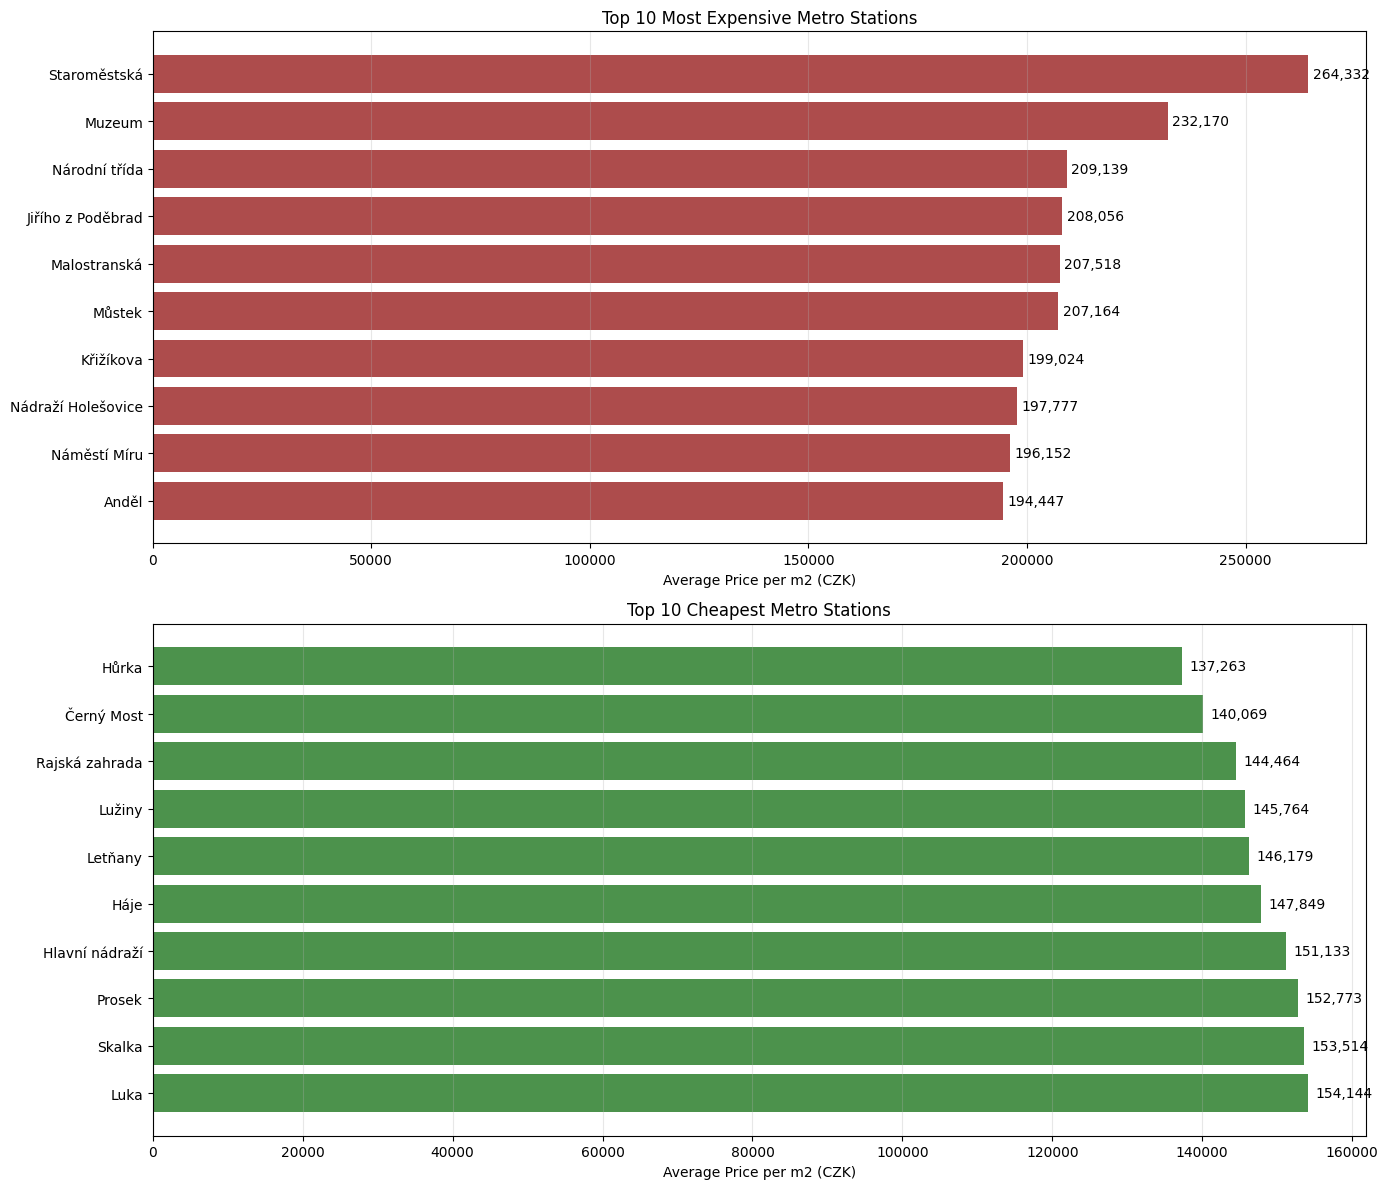

In [32]:
def show_market_analysis(df_encoded):

    df_encoded = pd.read_csv("data_estate_processed.csv")
    # Station prices
    df_encoded['price_per_m2'] = df_encoded['price'] / df_encoded['area_usable']
    
    # Aggregate statistics by station
    station_stats = df_encoded.groupby('nearest_station').agg({
        'price_per_m2': ['mean', 'min', 'max', 'count']
    }).round(0)
    
    # Flatten column names
    station_stats.columns = ['_'.join(col).strip() for col in station_stats.columns.values]
    station_stats = station_stats.rename(columns={
        'price_per_m2_mean': 'avg_price_m2',
        'price_per_m2_min': 'min_price_m2',
        'price_per_m2_max': 'max_price_m2',
        'price_per_m2_count': 'count'
    })
    
    # Sort by average price
    station_stats = station_stats.sort_values('avg_price_m2', ascending=False)

    print("Station Market Analysis")
    print(f"\nTop 10 Most Expensive Stations:\n{station_stats.head(10)}")
    print(f"\nTop 10 Cheapest Stations:\n{station_stats.tail(10)}")
    
   # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Top 10 most expensive stations
    top10 = station_stats.head(10)
    axes[0].barh(range(len(top10)), top10['avg_price_m2'], color='darkred', alpha=0.7)
    axes[0].set_yticks(range(len(top10)))
    axes[0].set_yticklabels(top10.index)
    axes[0].set_xlabel('Average Price per m2 (CZK)')
    axes[0].set_title('Top 10 Most Expensive Metro Stations')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(top10['avg_price_m2']):
        axes[0].text(v + 1000, i, f'{int(v):,}', va='center')
    
    # Top 10 cheapest stations
    bottom10 = station_stats.tail(10).sort_values('avg_price_m2', ascending=True)
    axes[1].barh(range(len(bottom10)), bottom10['avg_price_m2'], color='darkgreen', alpha=0.7)
    axes[1].set_yticks(range(len(bottom10)))
    axes[1].set_yticklabels(bottom10.index)
    axes[1].set_xlabel('Average Price per m2 (CZK)')
    axes[1].set_title('Top 10 Cheapest Metro Stations')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(bottom10['avg_price_m2']):
        axes[1].text(v + 1000, i, f'{int(v):,}', va='center')
    
    plt.tight_layout()
    plt.show()

show_market_analysis(df_encoded)

In [33]:
df_encoded.head(10)

,price,area_usable,has_elevator,has_terrace,latitude,longitude,floor_number,500m_atm_distance,500m_bus_public_transport_distance,500m_kindergarten_distance,...,nearest_station_Stodůlky,nearest_station_Strašnická,nearest_station_Střížkov,nearest_station_Vltavská,nearest_station_Vysočanská,nearest_station_Vyšehrad,nearest_station_Zličín,nearest_station_Černý Most,nearest_station_Českomoravská,nearest_station_Želivského
0,7505000.0,40,0,0,50.085363,14.447667,5,1,1,1,...,False,False,False,False,False,False,False,False,False,False
1,13950000.0,67,0,0,50.077742,14.407670,3,1,1,0,...,False,False,False,False,False,False,False,False,False,False
2,9490000.0,43,1,11,50.070650,14.449091,1,1,0,1,...,False,False,False,False,False,False,False,False,False,False
3,17990000.0,147,1,1,50.068352,14.370967,6,0,1,1,...,False,False,False,False,False,False,False,False,False,False
4,8300000.0,51,1,0,50.033314,14.415456,2,1,1,1,...,False,False,False,False,False,False,False,False,False,False
5,23990000.0,169,0,45,50.036203,14.343525,2,1,0,1,...,False,False,False,False,False,False,False,False,False,False
6,7290000.0,44,0,0,50.054125,14.441770,2,1,1,1,...,False,False,False,False,False,False,False,False,False,False
7,7290000.0,44,0,0,50.054125,14.441770,2,1,1,1,...,False,False,False,False,False,False,False,False,False,False
8,19700000.0,126,1,0,50.072838,14.381351,2,0,1,1,...,False,False,False,False,False,False,False,False,False,False
9,6570000.0,53,0,0,50.070191,14.399321,5,1,1,1,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# Prepare features and target
X = df_encoded.drop(columns=['price', 'latitude', 'longitude'], errors='ignore')
y = np.log(df_encoded['price'])

# Build OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)
y_pred = ols_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Model trained. MSE: {mse:.2f}, R²: {r2:.4f}")

Model trained. MSE: 0.03, R²: 0.8646


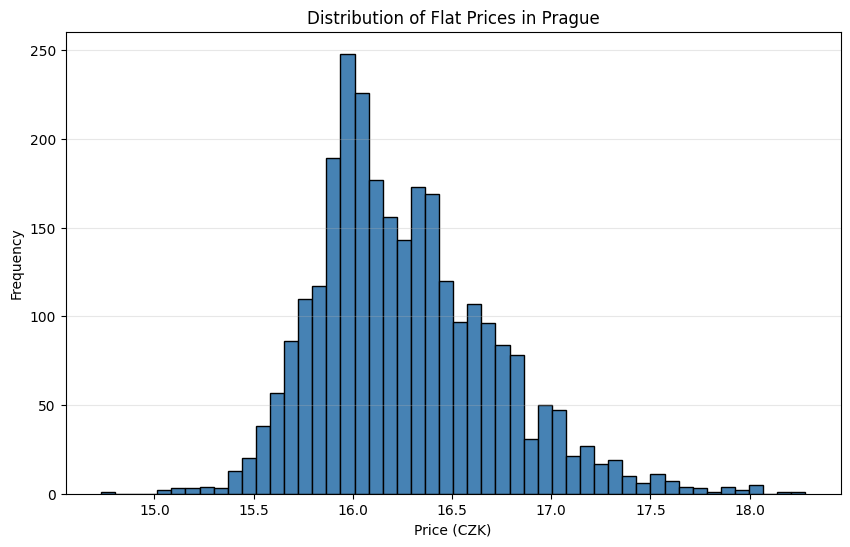

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, edgecolor='black', color='steelblue')
plt.xlabel('Price (CZK)')
plt.ylabel('Frequency')
plt.title('Distribution of Flat Prices in Prague')
plt.grid(axis='y', alpha=0.3)
plt.show()

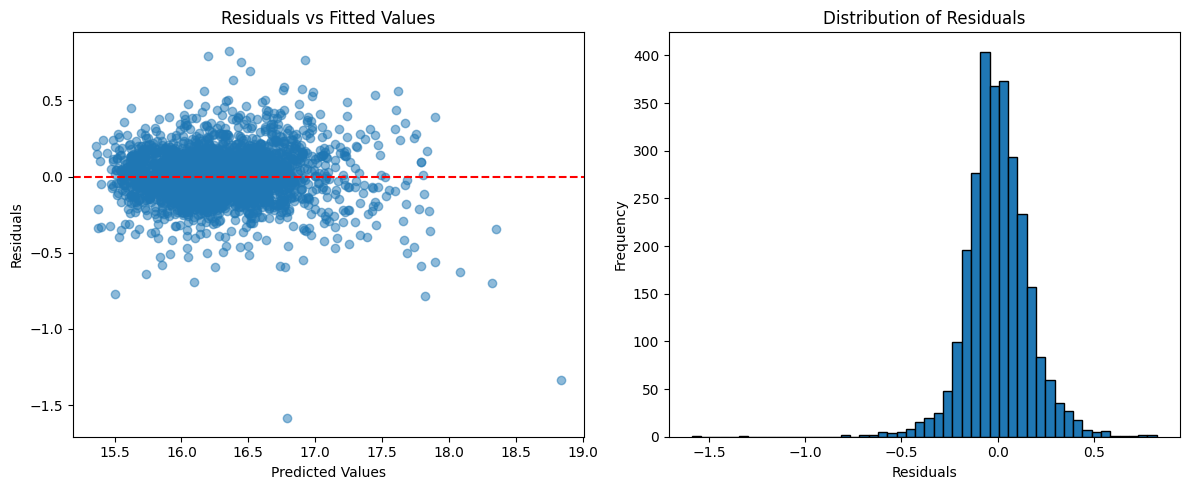

In [36]:
residuals = y - y_pred

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

In [37]:
# Test for heteroscedasticity using Breusch-Pagan test

# Add constant to X for the test
X_with_const = sm.add_constant(X)

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_with_const)

print("Breusch-Pagan Test for Heteroscedasticity:")
print(f"Test Statistic: {bp_test[0]:.4f}")
print(f"P-value: {bp_test[1]:.4f}")
print(f"Interpretation: {'Heteroscedasticity present (p < 0.05)' if bp_test[1] < 0.05 else 'Homoscedasticity assumed (p >= 0.05)'}")

Breusch-Pagan Test for Heteroscedasticity:
Test Statistic: 416.4134
P-value: 0.0000
Interpretation: Heteroscedasticity present (p < 0.05)


In [38]:
quantile_model = LinearRegression()
quantile_model.fit(X, y)
y_quantile_pred = quantile_model.predict(X)
mse_quantile = mean_squared_error(y, y_quantile_pred)
r2_quantile = r2_score(y, y_quantile_pred)
print(f"Quantile Model trained. MSE: {mse_quantile:.2f}, R²: {r2_quantile:.4f}")

Quantile Model trained. MSE: 0.03, R²: 0.8646


In [39]:
df_encoded.transpose()
df_encoded.to_csv("data_estate_processed_nb.csv", index=False)

In [40]:
X.to_csv("X_estate_processed_nb.csv", index=False)

In [41]:
if 'price' in df_encoded.columns:
    
    # Define X
    cols_to_drop = ['price', 'discount_show', 'lat', 'lon', 'latitude', 'longitude']

    # Drop all district and metro station columns to reduce multicollinearity
    dist_cols = [col for col in df_encoded.columns if col.startswith('district_')]
    metro_cols = [col for col in df_encoded.columns if col.startswith('1000m_')]
    dist_metro = [col for col in df_encoded.columns if col.startswith('metro_')]
    cols_to_drop.extend(dist_cols)
    cols_to_drop.extend(metro_cols)
    cols_to_drop.extend(dist_metro)
    
    X = df_encoded.drop(columns=cols_to_drop, errors='ignore')

    # 3. Robust Data Preparation (as before)
    # Convert bools
    bool_cols = X.select_dtypes(include=['bool']).columns
    X[bool_cols] = X[bool_cols].astype(int)
    
    # Convert all to numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Drop bad columns/rows
    X = X.dropna(axis=1, how='all')
    X = X.dropna()
    y = y.loc[X.index]
    
    # Add constant
    X = sm.add_constant(X)
        
    # OLS model for residuals
    print("OLS model...")
    ols_model = sm.OLS(y, X).fit()
    
    # Estimation of error variance (Heteroscedasticity)
    resid = ols_model.resid
    log_resid_sq = np.log(resid**2 + 1e-10) # epsilon for stability
    
    # Auxiliary regression to estimate variance
    var_model = sm.OLS(log_resid_sq, X).fit()
    
    # Estimated variance for each observation (exp(fitted))
    est_var = np.exp(var_model.fittedvalues)
    
    # GLS (resp. WLS with weights 1/variance)
    weights = 1.0 / est_var
    
    print("Training GLS (WLS) model...")
    # We use WLS, which is a form of GLS for diagonal variance matrix
    gls_model = sm.WLS(y, X, weights=weights).fit()
    
    print("\n" + "="*40)
    print("GLS (Feasible GLS)")
    print("="*40)
    print(gls_model.summary())

else:
    print("Error column 'price'.")

OLS model...
Training GLS (WLS) model...

GLS (Feasible GLS)
                            WLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.875
Model:                            WLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     200.3
Date:                Sat, 31 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:41:04   Log-Likelihood:                 1393.6
No. Observations:                2787   AIC:                            -2597.
Df Residuals:                    2692   BIC:                            -2034.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [42]:
VIF_factors = pd.DataFrame()
VIF_factors['Variable'] = X.columns
VIF_factors['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF_factors.sort_values(by='VIF', ascending=False).head(60)

/Users/michaldvoracek/miniconda3/envs/project_m4/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,const,213.791928
20,layout_2kk,16.136628
22,layout_3kk,15.082109
24,layout_4kk,8.570618
18,layout_1kk,7.098424
21,layout_31,5.344921
19,layout_21,4.186951
37,status_new,3.840766
26,layout_5kk,3.603185
1,area_usable,3.371052
